In [3]:
import pandas as pd

Transform Tabular Data to Textual to Simulate Real World Situation

In [4]:
def row_to_text(row):
    gender_map = {0: "male", 1: "female"}

    education_map = {
        1: "a bachelor's degree (type 1)",
        2: "a bachelor's degree (type 2)",
        3: "a master's degree",
        4: "a PhD"
    }

    strategy_map = {
        1: "an aggressive recruitment strategy",
        2: "a moderate recruitment strategy",
        3: "a conservative recruitment strategy"
    }

    return (
        f"The candidate is a {int(row['Age'])} year old {gender_map.get(row['Gender'], 'unspecified')} "
        f"with {education_map.get(row['EducationLevel'], 'unspecified')}. "
        f"They have {int(row['ExperienceYears'])} years of experience and have worked at "
        f"{int(row['PreviousCompanies'])} previous companies. "
        f"They live {row['DistanceFromCompany']:.1f} kilometers from the company. "
        f"Their interview score was {int(row['InterviewScore'])} out of 100, "
        f"skill score was {int(row['SkillScore'])} out of 100, and "
        f"personality score was {int(row['PersonalityScore'])} out of 100. "
        f"The candidate was sourced through {strategy_map.get(row['RecruitmentStrategy'], 'an unknown strategy')}."
    )


In [6]:
import pandas as pd

df = pd.read_csv("data.csv")

df["text"] = df.apply(row_to_text, axis=1)

print(df[["text", "HiringDecision"]].head())

                                                text  HiringDecision
0  The candidate is a 26 year old female with a b...               1
1  The candidate is a 39 year old female with a P...               1
2  The candidate is a 48 year old male with a bac...               0
3  The candidate is a 34 year old female with a b...               0
4  The candidate is a 30 year old male with a bac...               0


In [7]:
print(df["text"][0])


The candidate is a 26 year old female with a bachelor's degree (type 2). They have 0 years of experience and have worked at 3 previous companies. They live 26.8 kilometers from the company. Their interview score was 48 out of 100, skill score was 78 out of 100, and personality score was 91 out of 100. The candidate was sourced through an aggressive recruitment strategy.


Logistic Regression (80% male, 20% female)

In [79]:
from sklearn.model_selection import train_test_split

df["Gender"] = df["text"].str.extract(r'\b(male|female)\b')[0].map({"male": 0, "female": 1})

df_male = df[df["Gender"] == 0]
df_female = df[df["Gender"] == 1]

df_male_train, df_male_test = train_test_split(df_male, test_size=0.2, random_state=42)
df_female_train, df_female_test = train_test_split(df_female, test_size=0.5, random_state=42)

train_df = pd.concat([df_male_train, df_female_train])
test_df = pd.concat([df_male_test, df_female_test])

X_train, y_train = train_df["text"], train_df["HiringDecision"]
X_test, y_test = test_df["text"], test_df["HiringDecision"]


In [80]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

pipeline = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2), stop_words="english"),
    LogisticRegression(max_iter=1000)
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8256704980842912
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       362
           1       0.79      0.58      0.67       160

    accuracy                           0.83       522
   macro avg       0.81      0.76      0.78       522
weighted avg       0.82      0.83      0.82       522



Does hiring change by gender in the test set?

In [81]:
fair_df = test_df.copy()
fair_df["y_true"] = y_test.values
fair_df["y_pred"] = y_pred


In [82]:
true_hires = fair_df[fair_df["y_true"] == 1]

tpr_by_gender = true_hires.groupby("Gender")["y_pred"].mean()
print("True Positive Rate (Recall) by Gender:")
print(tpr_by_gender)


True Positive Rate (Recall) by Gender:
Gender
0    0.568182
1    0.586207
Name: y_pred, dtype: float64


Fairness Analysis

📊 Demographic Parity by Gender:
 Gender
0    0.209150
1    0.230352
Name: selection_rate, dtype: float64
🧮 Demographic Parity Difference: 0.021201976725649607


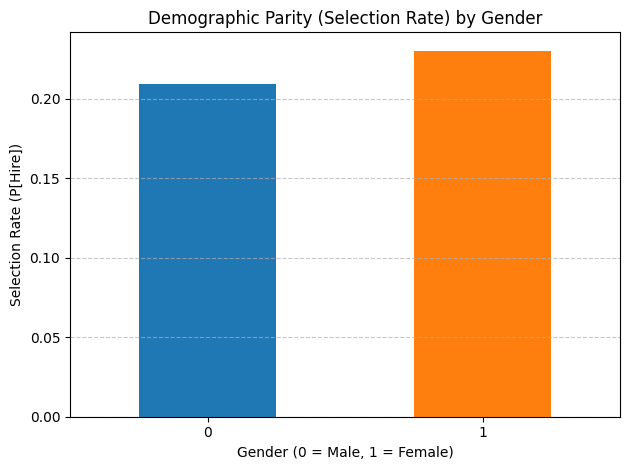

In [83]:
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

sensitive_features = test_df["Gender"].reset_index(drop=True)

dp_metric = MetricFrame(
    metrics=selection_rate,
    y_true=y_test.reset_index(drop=True),
    y_pred=y_pred,
    sensitive_features=sensitive_features
)

print("📊 Demographic Parity by Gender:\n", dp_metric.by_group)
print("🧮 Demographic Parity Difference:", dp_metric.difference())

dp_metric.by_group.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.title("Demographic Parity (Selection Rate) by Gender")
plt.ylabel("Selection Rate (P[Hire])")
plt.xlabel("Gender (0 = Male, 1 = Female)")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Equal Opportunity

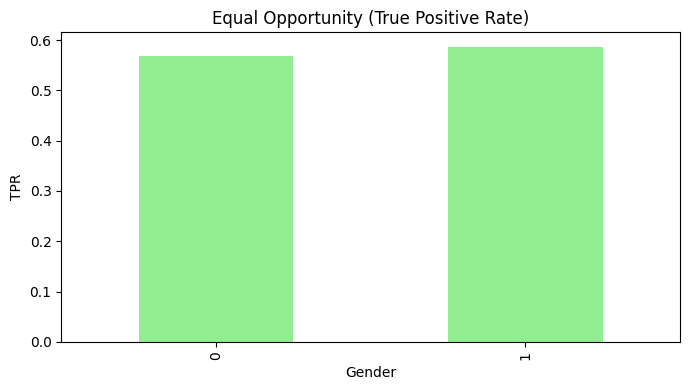

In [86]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))
eopp.by_group.plot(kind='bar', ax=ax, color='lightgreen')
ax.set_title("Equal Opportunity (True Positive Rate)")
ax.set_ylabel("TPR")
ax.set_xlabel("Gender")
plt.tight_layout()
plt.show()


Average Odds

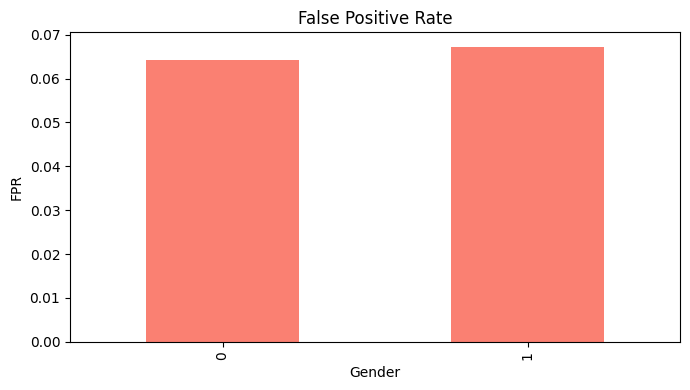

In [87]:
fig, ax = plt.subplots(figsize=(7, 4))
fpr.by_group.plot(kind='bar', ax=ax, color='salmon')
ax.set_title("False Positive Rate")
ax.set_ylabel("FPR")
ax.set_xlabel("Gender")
plt.tight_layout()
plt.show()


Explain Five Predictions Using SHAP

In [102]:
import shap
import pandas as pd
from IPython.display import display, Markdown

test_df = pd.DataFrame({"text": X_test, "HiringDecision": y_test})
test_df["y_pred"] = pipeline.predict(test_df["text"])
test_df["y_prob"] = pipeline.predict_proba(test_df["text"])[:, 1]

pos_samples = test_df[test_df["y_pred"] == 1].sample(3, random_state=42)
neg_samples = test_df[test_df["y_pred"] == 0].sample(2, random_state=42)
samples = pd.concat([pos_samples, neg_samples]).reset_index(drop=True)



In [103]:
texts = samples["text"].tolist()

In [104]:
vectorizer = pipeline.named_steps["tfidfvectorizer"]
model = pipeline.named_steps["logisticregression"]

In [105]:
def predict_proba(texts):
    X = vectorizer.transform(texts)
    return model.predict_proba(X)

In [106]:
masker = shap.maskers.Text()
explainer = shap.Explainer(predict_proba, masker)
shap_values = explainer(texts)

In [108]:
for i, text in enumerate(texts):
    pred = samples.loc[i, "y_pred"]
    prob = samples.loc[i, "y_prob"]
    label = f"Hire  ({prob:.2f})" if pred == 1 else f"No-Hire ({prob:.2f})"

    display(Markdown(f"### Sample {i+1} | Prediction: **{label}**"))
    display(Markdown(f"```\n{text}\n```"))

### ✍️ Sample 1 | Prediction: **Hire ✅ (0.56)**

```
The candidate is a 49 year old female with a master's degree. They have 12 years of experience and have worked at 4 previous companies. They live 23.5 kilometers from the company. Their interview score was 29 out of 100, skill score was 34 out of 100, and personality score was 48 out of 100. The candidate was sourced through an aggressive recruitment strategy.
```

### ✍️ Sample 2 | Prediction: **Hire ✅ (0.75)**

```
The candidate is a 29 year old male with a master's degree. They have 5 years of experience and have worked at 5 previous companies. They live 11.0 kilometers from the company. Their interview score was 62 out of 100, skill score was 92 out of 100, and personality score was 11 out of 100. The candidate was sourced through an aggressive recruitment strategy.
```

### ✍️ Sample 3 | Prediction: **Hire ✅ (0.74)**

```
The candidate is a 24 year old female with a master's degree. They have 6 years of experience and have worked at 1 previous companies. They live 42.9 kilometers from the company. Their interview score was 48 out of 100, skill score was 88 out of 100, and personality score was 96 out of 100. The candidate was sourced through an aggressive recruitment strategy.
```

### ✍️ Sample 4 | Prediction: **No-Hire ❌ (0.10)**

```
The candidate is a 25 year old male with a bachelor's degree (type 2). They have 7 years of experience and have worked at 3 previous companies. They live 1.8 kilometers from the company. Their interview score was 0 out of 100, skill score was 49 out of 100, and personality score was 20 out of 100. The candidate was sourced through a moderate recruitment strategy.
```

### ✍️ Sample 5 | Prediction: **No-Hire ❌ (0.14)**

```
The candidate is a 20 year old female with a bachelor's degree (type 2). They have 5 years of experience and have worked at 3 previous companies. They live 47.1 kilometers from the company. Their interview score was 34 out of 100, skill score was 34 out of 100, and personality score was 92 out of 100. The candidate was sourced through a moderate recruitment strategy.
```

Counterfactual Augmentation

In [128]:
import pandas as pd
import numpy as np
import re

def flip_gender_terms(text):
    swaps = {
        r"\bhe\b": "she",
        r"\bshe\b": "he",
        r"\bhis\b": "her",
        r"\bher\b": "his",
        r"\bman\b": "woman",
        r"\bwoman\b": "man",
        r"\bmale\b": "female",
        r"\bfemale\b": "male"
    }

    for pat, replacement in swaps.items():
        text = re.sub(pat, replacement, text, flags=re.IGNORECASE)
    return text


Flip Gender

In [129]:
counterfactual_train_df = train_df.copy()
counterfactual_train_df["text"] = counterfactual_train_df["text"].apply(flip_gender_terms)

In [145]:
augmented_train_df = pd.concat([train_df, counterfactual_train_df], ignore_index=True)

X_train_aug = augmented_train_df["text"]
y_train_aug = augmented_train_df["HiringDecision"]

X_test = test_df["text"]
y_test = test_df["HiringDecision"]


In [146]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

aug_pipeline = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2), stop_words="english"),
    LogisticRegression(max_iter=1000)
)

aug_pipeline.fit(X_train_aug, y_train_aug)


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [147]:
y_pred_aug = aug_pipeline.predict(X_test)

Accuracy After Counterfactual Augmentation

In [148]:
print("Accuracy After:", accuracy_score(y_test, y_pred_aug))
print("Classification Report After:\n", classification_report(y_test, y_pred_aug))


Accuracy After: 0.8467432950191571
Classification Report After:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89       362
           1       0.81      0.66      0.72       160

    accuracy                           0.85       522
   macro avg       0.83      0.79      0.81       522
weighted avg       0.84      0.85      0.84       522

